# RNetwork Training

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import torch
import numpy as np

from tqdm import tqdm
from omegaconf import OmegaConf

import envs
import utils
import envs.pusher_utils as pusher_utils

from rnet.model import RNetModel
from rnet.memory import RNetMemory
from rnet.dataset import RNetPairsSplitDataset
from exploration_buffer import ExplorationBuffer
from rnet.utils import *

from matplotlib import colors
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Config Utils

In [3]:
cfg_path = f"../conf/config.yaml"

env_name = 'pusher'

cfg = OmegaConf.load(cfg_path)
env_cfg = OmegaConf.load(f'../conf/env/{env_name}.yaml')

cfg = OmegaConf.merge(cfg, env_cfg)

space_info = utils.get_space_info(cfg.env.obs, cfg.env.action_dim)
device = torch.device("cuda:1")

/private/home/linamezghani/.conda/envs/polybeast/lib/python3.7/site-packages/omegaconf/resolvers/__init__.py:13: UserWarning: The `env` resolver is deprecated, see https://github.com/omry/omegaconf/issues/573
  "The `env` resolver is deprecated, see https://github.com/omry/omegaconf/issues/573"


In [4]:
env = envs.make_env(cfg.env, space_info)

pygame 2.0.1 (SDL 2.0.14, Python 3.7.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


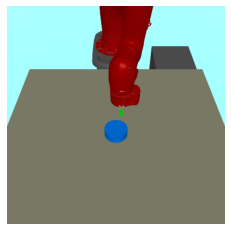

In [5]:
plt.imshow(env.render(mode='rgb_array'))
plt.axis('off')
plt.show()

## RNet dataset

In [6]:
print(cfg.rnet.dataset)

{'thresh': 10, 'neg_thresh': 0, 'in_traj_ratio': 0.5, 'neg_ratio': 0.5, 'symmetric': True, 'valid_ratio': 0.05, 'num_pairs': {'train': 500000, 'val': 100000}}


In [112]:
cfg.rnet.dataset.thresh = 10
cfg.rnet.dataset.symmetric = False

cfg.exploration_buffer.data_dir = "/checkpoint/linamezghani/offline-gcrl/data/pusher/random-rsp1000"
expl_buffer = ExplorationBuffer(cfg.exploration_buffer)

dataset = RNetPairsSplitDataset(cfg.rnet.dataset, expl_buffer)

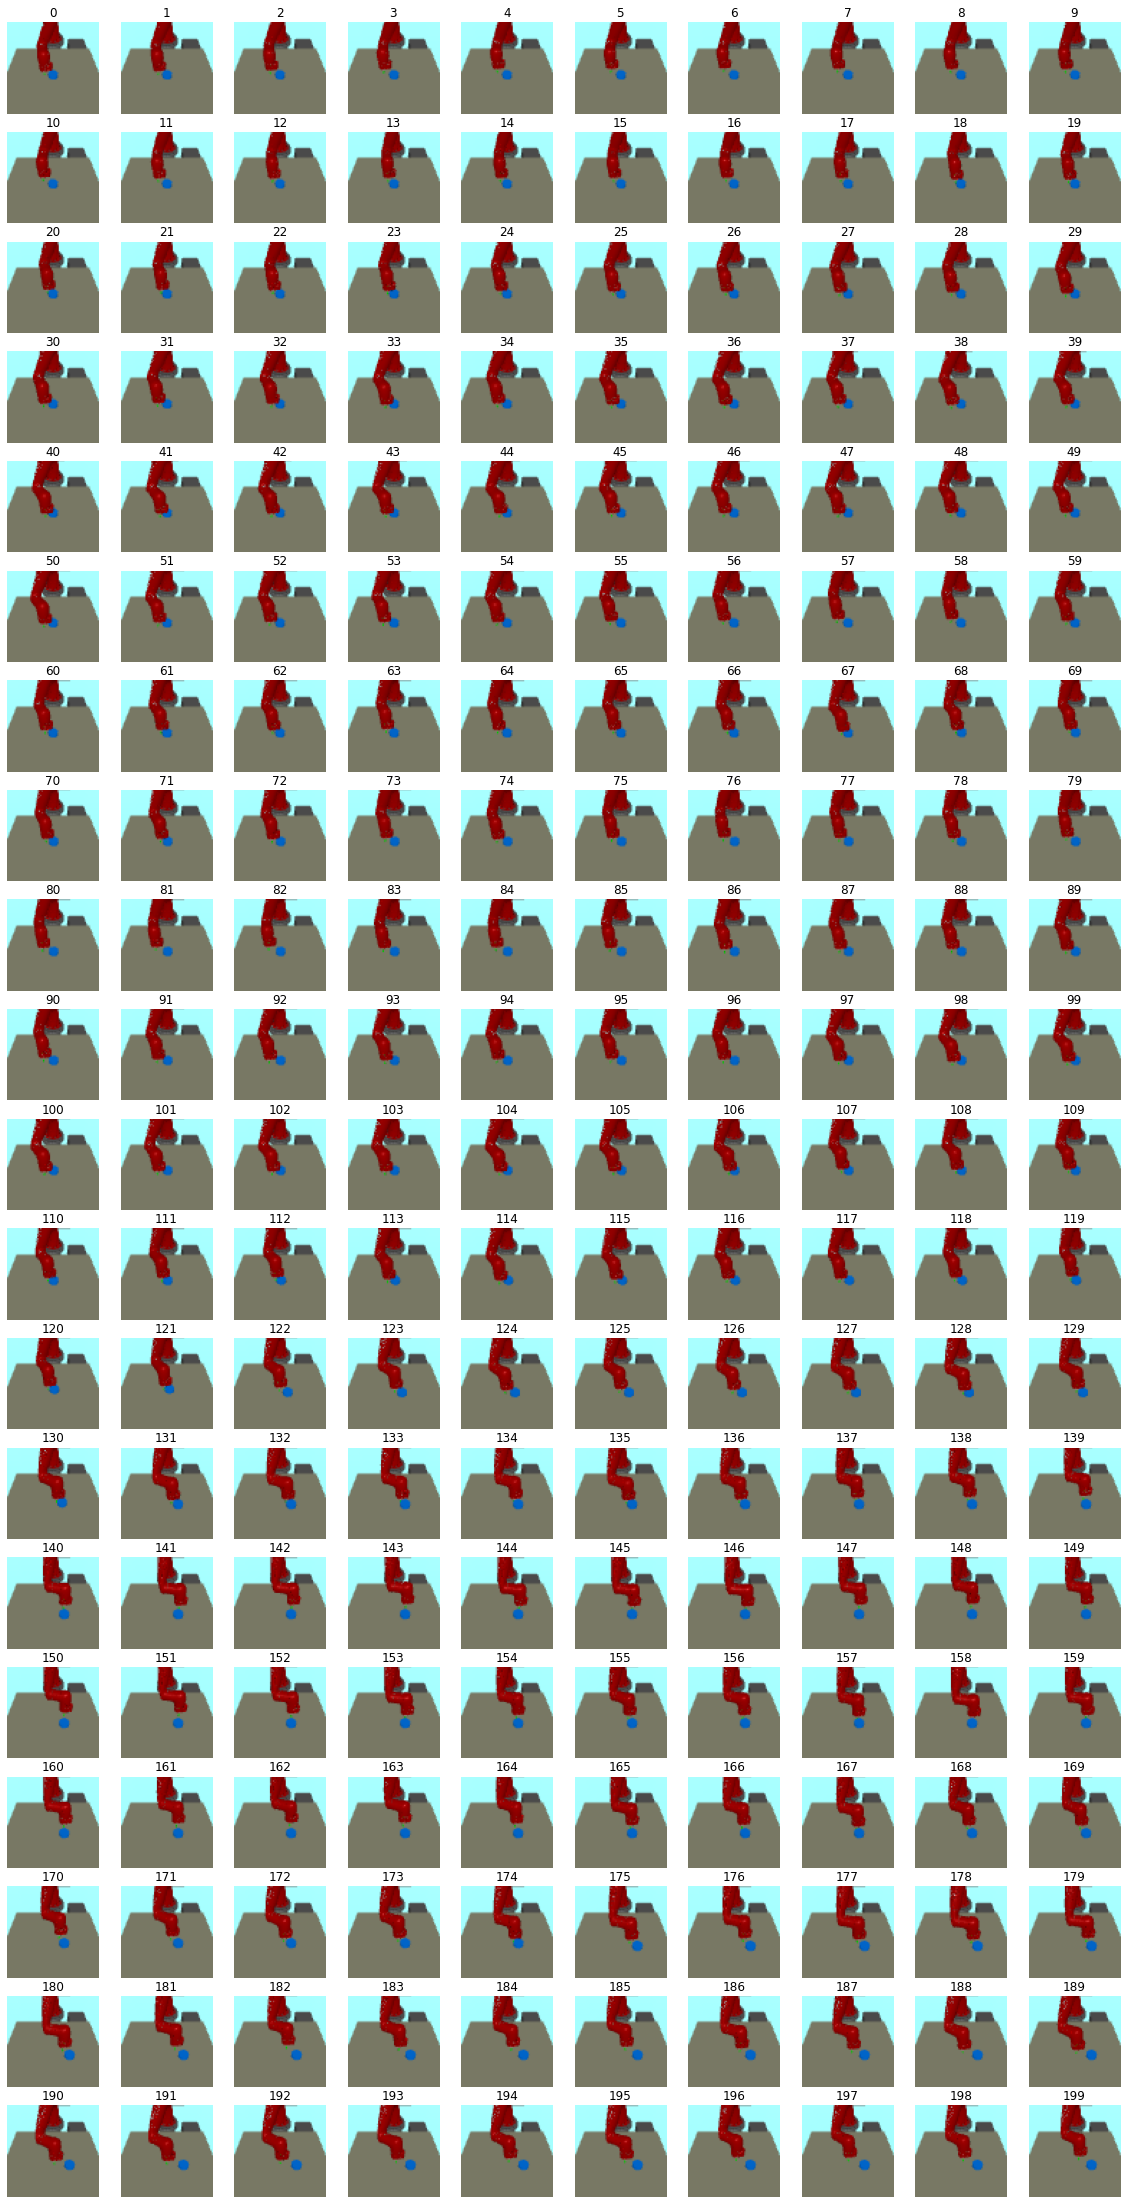

In [10]:
n = 200
num_cols = 10
num_rows = n // num_cols + int(n % num_cols != 0)

fig, ax = plt.subplots(num_rows, num_cols, figsize=(2 * num_cols, 2 *
            num_rows))
traj_idx = np.random.randint(expl_buffer.states.shape[0])

for i in range(n):
    state = expl_buffer.states[traj_idx][i]
    img = env.get_image_from_obs(state)
    ax[i // num_cols, i % num_cols].imshow(img.transpose((1, 2, 0)))
    ax[i // num_cols, i % num_cols].axis('off')
    ax[i // num_cols, i % num_cols].set_title(str(i))

plt.show()

## Train RNet

In [113]:
cfg.rnet.model.remove_velocity = False

model = RNetModel(cfg.rnet.model, space_info)
model = model.to(device)

print(model)

RNetModel(
  (encoder): FeatureEncoder(
    (net): Sequential(
      (0): Linear(in_features=4, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
      (3): Linear(in_features=64, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Tanh()
      (6): Linear(in_features=64, out_features=16, bias=True)
    )
  )
  (comparator): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=2, bias=True)
  )
)


In [114]:
model.train()
cfg.rnet.train.num_epochs = 20

stats = train(cfg.rnet.train, model, dataset, device)

rnet epoch 0 - train loss 0.36,  acc 0.87 - val loss 0.26,  acc 0.90
rnet epoch 1 - train loss 0.24,  acc 0.91 - val loss 0.23,  acc 0.91
rnet epoch 2 - train loss 0.22,  acc 0.91 - val loss 0.22,  acc 0.91
rnet epoch 3 - train loss 0.22,  acc 0.91 - val loss 0.21,  acc 0.92
rnet epoch 4 - train loss 0.22,  acc 0.91 - val loss 0.21,  acc 0.92
rnet epoch 5 - train loss 0.21,  acc 0.92 - val loss 0.21,  acc 0.92
rnet epoch 6 - train loss 0.21,  acc 0.92 - val loss 0.21,  acc 0.92
rnet epoch 7 - train loss 0.21,  acc 0.92 - val loss 0.21,  acc 0.92
rnet epoch 8 - train loss 0.21,  acc 0.92 - val loss 0.21,  acc 0.92
rnet epoch 9 - train loss 0.21,  acc 0.92 - val loss 0.21,  acc 0.92
rnet epoch 10 - train loss 0.21,  acc 0.92 - val loss 0.21,  acc 0.92
rnet epoch 11 - train loss 0.21,  acc 0.92 - val loss 0.20,  acc 0.92
rnet epoch 12 - train loss 0.21,  acc 0.92 - val loss 0.20,  acc 0.92
rnet epoch 13 - train loss 0.21,  acc 0.92 - val loss 0.21,  acc 0.92
rnet epoch 14 - train loss 0.2

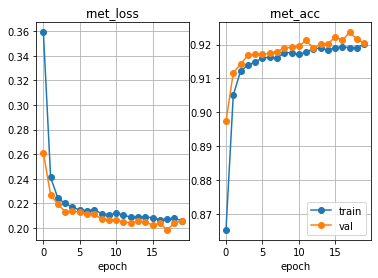

In [115]:
epochs = list(stats.keys())

new_stats = {}
for epoch in epochs:
    for phase in stats[epoch]:
        if not phase in new_stats:
            new_stats[phase] = {}
        for stat, v in stats[epoch][phase].items():
            if not stat in new_stats[phase]:
                new_stats[phase][stat] = []
            if isinstance(v, torch.Tensor):
                v = v.item()
            new_stats[phase][stat].append(v)

fig, ax = plt.subplots(1, 2)
i = 0
for stat in ['rnet_loss', 'rnet_acc']:
    for phase in ['train', 'val']:
        ax[i].plot(epochs, new_stats[phase][stat], label=phase, marker='o')
    ax[i].grid()
    ax[i].set_title(stat)
    ax[i].set_xlabel('epoch')
    i += 1
ax[1].legend()
plt.show()

In [116]:
model.to(device)
model.eval()

RNetModel(
  (encoder): FeatureEncoder(
    (net): Sequential(
      (0): Linear(in_features=4, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
      (3): Linear(in_features=64, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Tanh()
      (6): Linear(in_features=64, out_features=16, bias=True)
    )
  )
  (comparator): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=2, bias=True)
  )
)

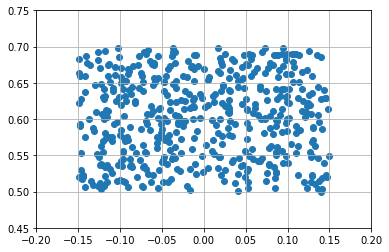

In [117]:
fig = env.plot_goals()

In [118]:
points = env.goals

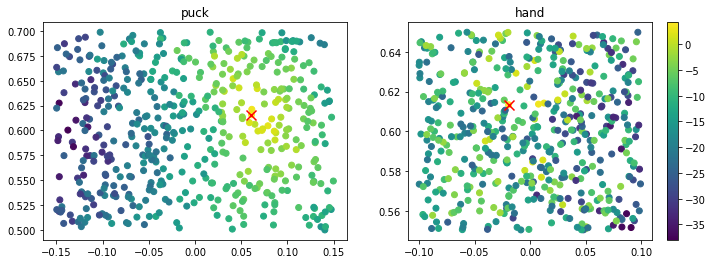

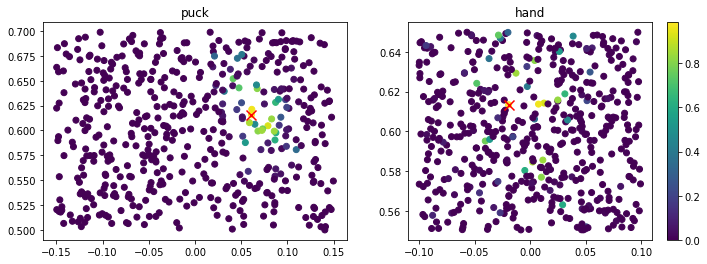

In [119]:
model.to('cpu')

i = np.random.randint(0, points['state'].shape[0])
fig = env.plot_values(
    model, points['state'][i], points['state'][i], points['state'], points['state'], sigmoid=False
)
fig = env.plot_values(
    model, points['state'][i], points['state'][i], points['state'], points['state'], sigmoid=True
)

In [120]:
model.to(device)

embs = embed_expl_buffer(expl_buffer, model, device)
expl_buffer.set_embs(embs)

embed exploration buffer: 100%|██████████| 10000/10000 [00:02<00:00, 4181.50it/s]


## Build Memory

In [121]:
cfg.rnet.memory.capacity = 1000
cfg.rnet.memory.directed = True

In [122]:
model.to(device)

memory = RNetMemory(cfg.rnet.memory, space_info, model.feat_size, device)

memory.build(model, expl_buffer)

Updating Memory: 100%|██████████| 10000/10000 [03:33<00:00, 46.74it/s]

num obs seen: 99999
memory_len : 595


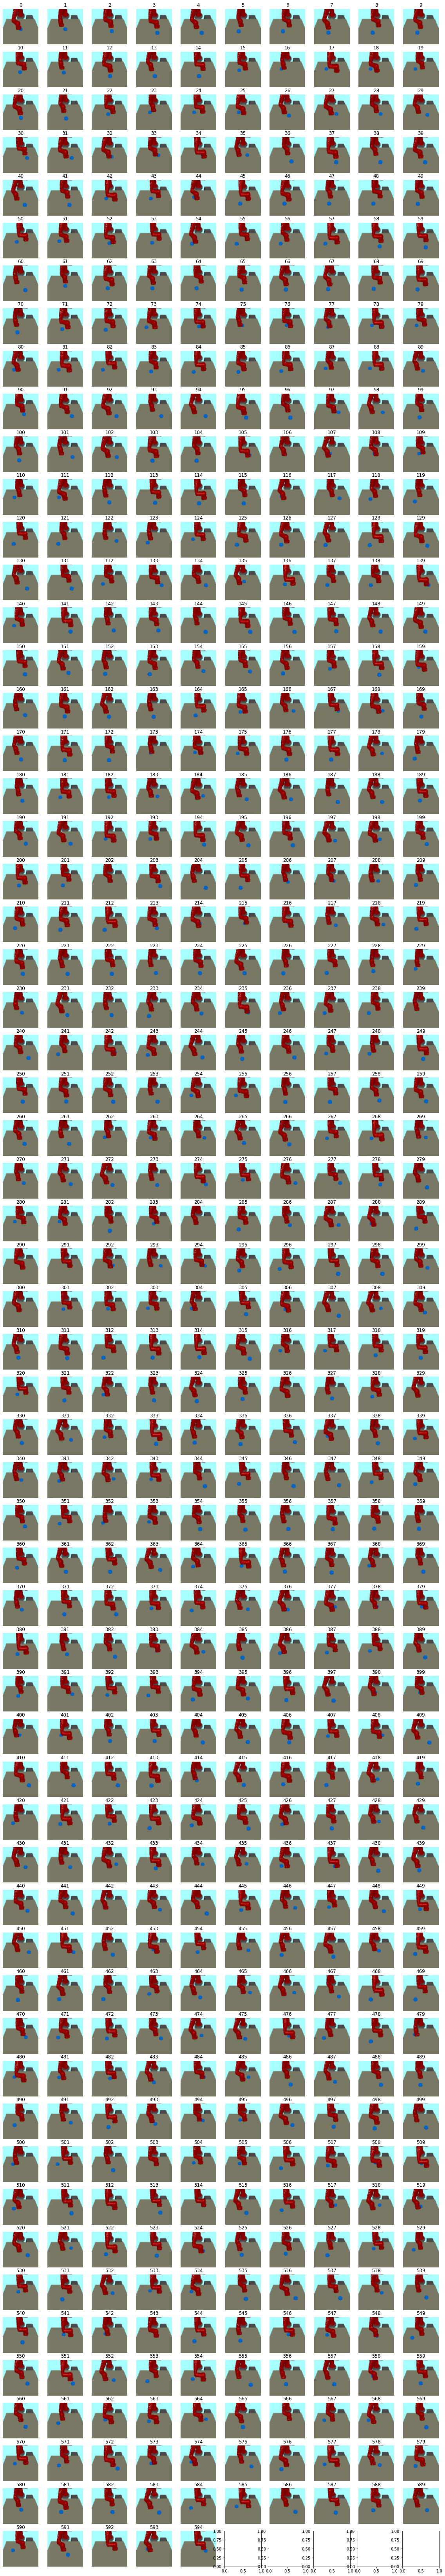

In [123]:
n = len(memory)
num_cols = 10
num_rows = n // num_cols + int(n % num_cols != 0)

fig, ax = plt.subplots(num_rows, num_cols, figsize=(2 * num_cols, 2 * num_rows))

for i in range(n):
    state = memory.states[i]
    img = env.get_image_from_obs(state)
    ax[i // num_cols, i % num_cols].imshow(img.transpose((1, 2, 0)))
    ax[i // num_cols, i % num_cols].axis('off')
    ax[i // num_cols, i % num_cols].set_title(str(i))
plt.show()

In [124]:
nn = memory.compute_NN(expl_buffer.embs, model)
expl_buffer.embs = expl_buffer.embs.to("cpu")
memory.set_nn(nn)

computing NN: 100%|██████████| 10000/10000 [00:49<00:00, 200.51it/s]


In [125]:
memory.compute_edges(model)

computing edges: 100%|██████████| 10000/10000 [02:46<00:00, 59.91it/s]


There are 11 components. Connecting 0.
There are 7 components. Connecting 0.
There are 6 components. Connecting 0.
There are 6 components. Connecting 0.
There are 4 components. Connecting 0.
There are 3 components. Connecting 0.
There are 2 components. Connecting 0.


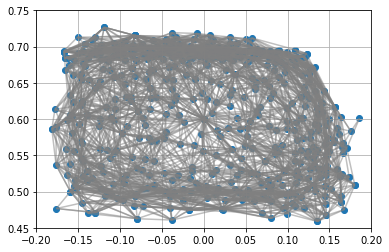

In [126]:
fig = env.plot_graph(memory)

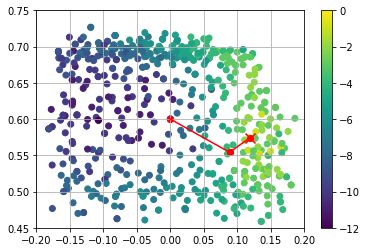

In [139]:
fig = env.plot_graph_dist(memory, start=0)

out


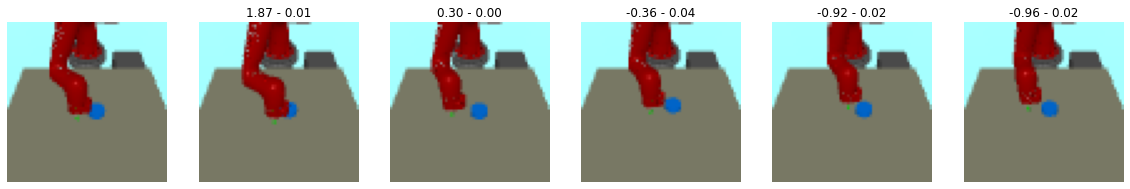

in


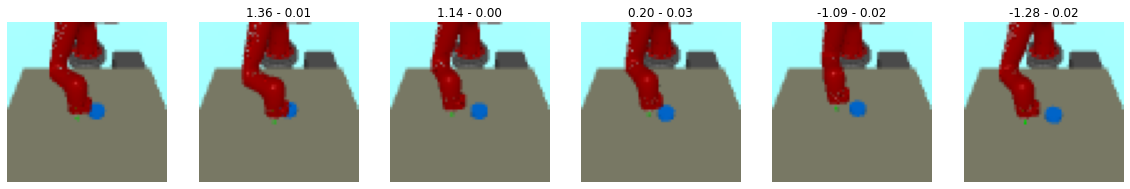

In [128]:
def show_kNN(env, model, memory, obs, state, k=9):
    model.to(device)
    obs_torch = torch.from_numpy(obs).unsqueeze(0).float().to(device)
    e = model.get_embedding(obs_torch)
    out_o = memory.compare_embeddings(e, model)
    out_i = memory.compare_embeddings(e, model, incoming_dir=True)
    idx_o =  torch.argsort(out_o, descending=True)
    idx_i =  torch.argsort(out_i, descending=True)
    
    print("out")
    fig, ax = plt.subplots(1, k + 1, figsize=(20, 5))
    img = env.get_image_from_obs(state)
    ax[0].imshow(img.transpose((1, 2, 0)))
    ax[0].axis('off')
    for i in range(k):
        state_NN = memory.states[idx_o[i]]
        img = env.get_image_from_obs(state_NN)
        ax[i+1].imshow(img.transpose((1, 2, 0)))
        ax[i+1].set_title(f"{out_o[idx_o[i]]:.2f} - {env.oracle_distance(state[:9], state_NN[:9]):.2f}")
        ax[i+1].axis('off')
    plt.show()
    
    
    print("in")
    fig, ax = plt.subplots(1, k + 1, figsize=(20, 5))
    img = env.get_image_from_obs(state)
    ax[0].imshow(img.transpose((1, 2, 0)))
    ax[0].axis('off')
    for i in range(k):
        state_NN = memory.states[idx_i[i]]
        img = env.get_image_from_obs(state_NN)
        ax[i+1].imshow(img.transpose((1, 2, 0)))
        ax[i+1].set_title(f"{out_i[idx_i[i]]:.2f} - {env.oracle_distance(state[:9], state_NN[:9]):.2f}")
        ax[i+1].axis('off')
    plt.show()
    
obs, i, j = expl_buffer.get_random_obs()

#i, j = 6486, 513
#i, j = 7080, 198
#obs = expl_buffer.get_obs(i, j)
state = expl_buffer.states[i, j]
#state = env.goals['state'][i]
#obs = env.goals['vec_obs'][i]
show_kNN(env, model, memory, obs, state, k=5)

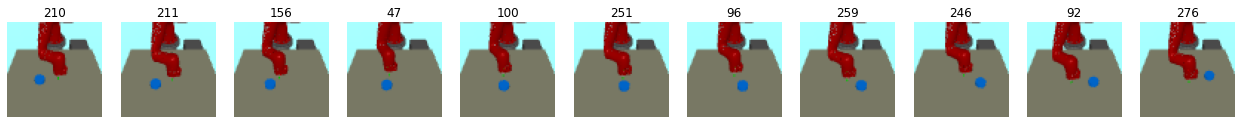

In [137]:
def retrieve_path(pred, i, j):
    if pred[i, j] == -9999:
        return [i]
    path = retrieve_path(pred, i, pred[i, j])
    path.append(j)
    return path

def show_path(env, memory, i, j):
    path = retrieve_path(memory.pred, i, j)
    n = len(path)
    num_cols = n
    num_rows = 1
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(2 * num_cols, 2 *
            num_rows))
    for p in range(n):
        state = memory.states[path[p]]
        img = env.get_image_from_obs(state)
        ax[p].imshow(img.transpose((1, 2, 0)))
        ax[p].axis('off')
        ax[p].set_title(str(path[p]))
    plt.show()
    
i, j = np.random.randint(len(memory)), np.random.randint(len(memory))
#j=42
show_path(env, memory, i, j)

## Save

In [ ]:
exp_name = 'pusher_thresh5'
save_dir = os.path.join('/checkpoint/linamezghani/offline-gcrl/rnet/', exp_name)

save(save_dir, model, memory)